Intro

### **1. Initiate libraries and paths**

In [15]:
import PyPDF2
from transformers import pipeline
import os
from glob import glob
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re

# Folder paths for txt files
abstracts_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Abstracts'
pdf_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature'

### **2. Create word cloud**

In [2]:
# Load text from all txt files
abstract_texts = []
for file in glob(os.path.join(abstracts_folder, "*.txt")):
    with open(file, 'r', encoding='utf-8') as f:
        abstract_texts.append(f.read())

# Print the number of abstracts read
print(f"Number of abstracts read: {len(abstract_texts)}")

# Join all abstracts into one text for word cloud generation
all_abstracts_text = " ".join(abstract_texts)

Number of abstracts read: 88


In [13]:
# # Use the same processing rules as WordCloud for tokenization and stopword removal
# def process_text_for_wordcloud(text, stopwords):
#     words = text.lower().split()
#     # Remove stopwords and non-alphabetic tokens
#     cleaned_words = [word.strip(".,!?\"':;()[]{}") for word in words if word not in stopwords]
#     return cleaned_words

# # Process the text using WordCloud's stopwords
# stopwords = set(STOPWORDS)
# processed_tokens = process_text_for_wordcloud(all_abstracts_text, stopwords)

# # Count word frequencies
# word_counts = Counter(processed_tokens)

# # Get the top 25 words
# top_25_words = word_counts.most_common(25)

# # Print the top 25 words
# print("Top 25 words in the word cloud:")
# for word, count in top_25_words:
#     print(f"{word}: {count}")

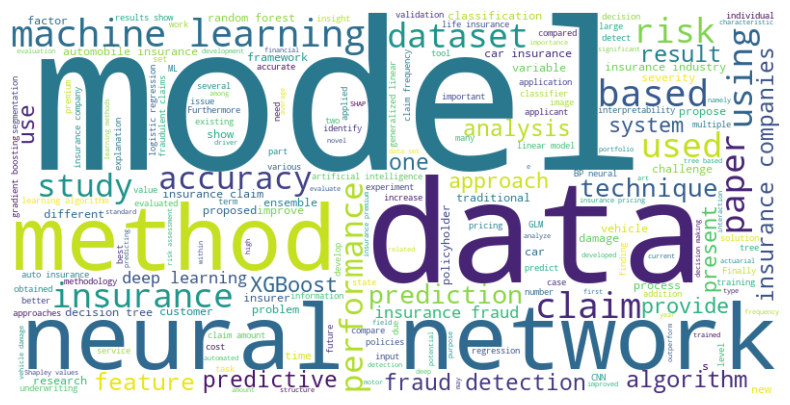

In [4]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_abstracts_text)

# Display the word cloud
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **3. Word counter on words of interest**

In [ ]:
# Initiate empty dict
pdf_texts = {}

# Use glob to find all PDFs in subfolders
for file in glob(os.path.join(pdf_folder, "**", "*.pdf"), recursive=True):
    pdf_text = ""
    with open(file, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            pdf_text += pdf_reader.pages[page_num].extract_text()
    
    # Extract the subfolder name
    subfolder_name = os.path.basename(os.path.dirname(file))

    # Store everything
    pdf_texts[(os.path.basename(file), subfolder_name)] = pdf_text

Invalid parent xref., rebuild xref


In [ ]:
# List of insurance-related words
interest_words = [
    'neural network'
    , 'gbm'
    , 'xgboost'
    , 'random forest'
    , 'decision tree'
    , 'tree'
    , 'logistic'
    , 'linear regression'
    , 'genetic algorithm'
    , 'explainability'
    , 'interpretability'
    , 'explainable AI'
    , 'explainable artificial intelligence'
    , 'xai'
    , 'fairness'
    , 'lime'
    , 'shapley'
    , 'shap'
    , 'partial dependence plots'
    , 'feature importance'
    , 'surrogate']

In [11]:
pdf_word_counts = []

for (filename, subfolder), text in pdf_texts.items():
    # Remove the '.pdf' extension
    title = filename.replace('.pdf', '')

    # Extract the publication year (last 4 characters)
    publication_year = None
    if len(title) >= 4 and title[-4:].isdigit():
        publication_year = int(title[-4:])
        # Remove the publication year from the title
        title = title[:-4].strip()

    # Convert text to lowercase
    text_lower = text.lower()
    count_data = {
        'title': title,
        'subdomain': subfolder,
        'publication_year': publication_year}
    
    # Count function
    for term in interest_words:
        if " " in term:  
            count = len(re.findall(r'\b' + re.escape(term) + r'\b', text_lower))
        else:  
            count = text_lower.split().count(term)
        
        count_data[term] = count
    
    pdf_word_counts.append(count_data)

df_word_counts = pd.DataFrame(pdf_word_counts)

In [12]:
df_word_counts

,title,subdomain,publication_year,neural network,gbm,xgboost,random forest,decision tree,tree,logistic,...,explainability,explainable,xai,fairness,lime,shapley,shap,partial dependence plots,feature importance,interpretability
0,A Deep Learning and Transfer Learning Approach...,Claims_handling,2021,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Automated Car Damage Assessment Using Computer...,Claims_handling,2024,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Automated Detection of Multi-class Vehicle Ext...,Claims_handling,2021,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Automated vehicle damage classification,Claims_handling,2024,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Automatic damaged vehicle estimator using enha...,Claims_handling,2023,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Automated Underwriting in Life Insurance Predi...,Underwriting,2018,1,0,12,1,0,3,18,...,0,0,0,0,0,0,0,0,4,2
84,Improving the Accuracy and Transparency of Und...,Underwriting,2020,1,0,0,0,0,0,0,...,1,0,0,5,0,2,10,0,2,1
85,Risk prediction in life insurance industry usi...,Underwriting,2018,10,0,0,0,10,26,0,...,0,0,0,0,0,0,0,0,0,0
86,Smart_Underwriting_System_An_Intelligent_Decis...,Underwriting,2018,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#df_word_counts.to_csv('C:/Users/bart_/Documents/Ethical_AI/Assignment/chk_word_counts.csv')

### **4. Visualizations**

**4.1 References per publication year**

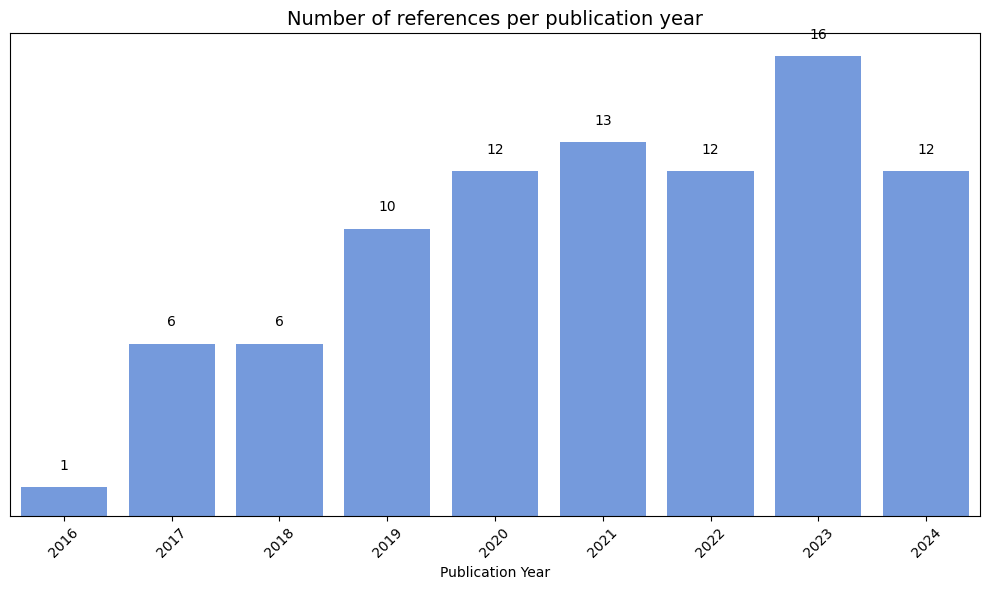

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_word_counts, x='publication_year', color='cornflowerblue', order=sorted(df_word_counts['publication_year'].unique()))

# Add data labels above each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

ax.yaxis.set_visible(False)

# Add titles and labels
plt.title('Number of references per publication year', fontsize=14)
plt.xlabel('Publication Year', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

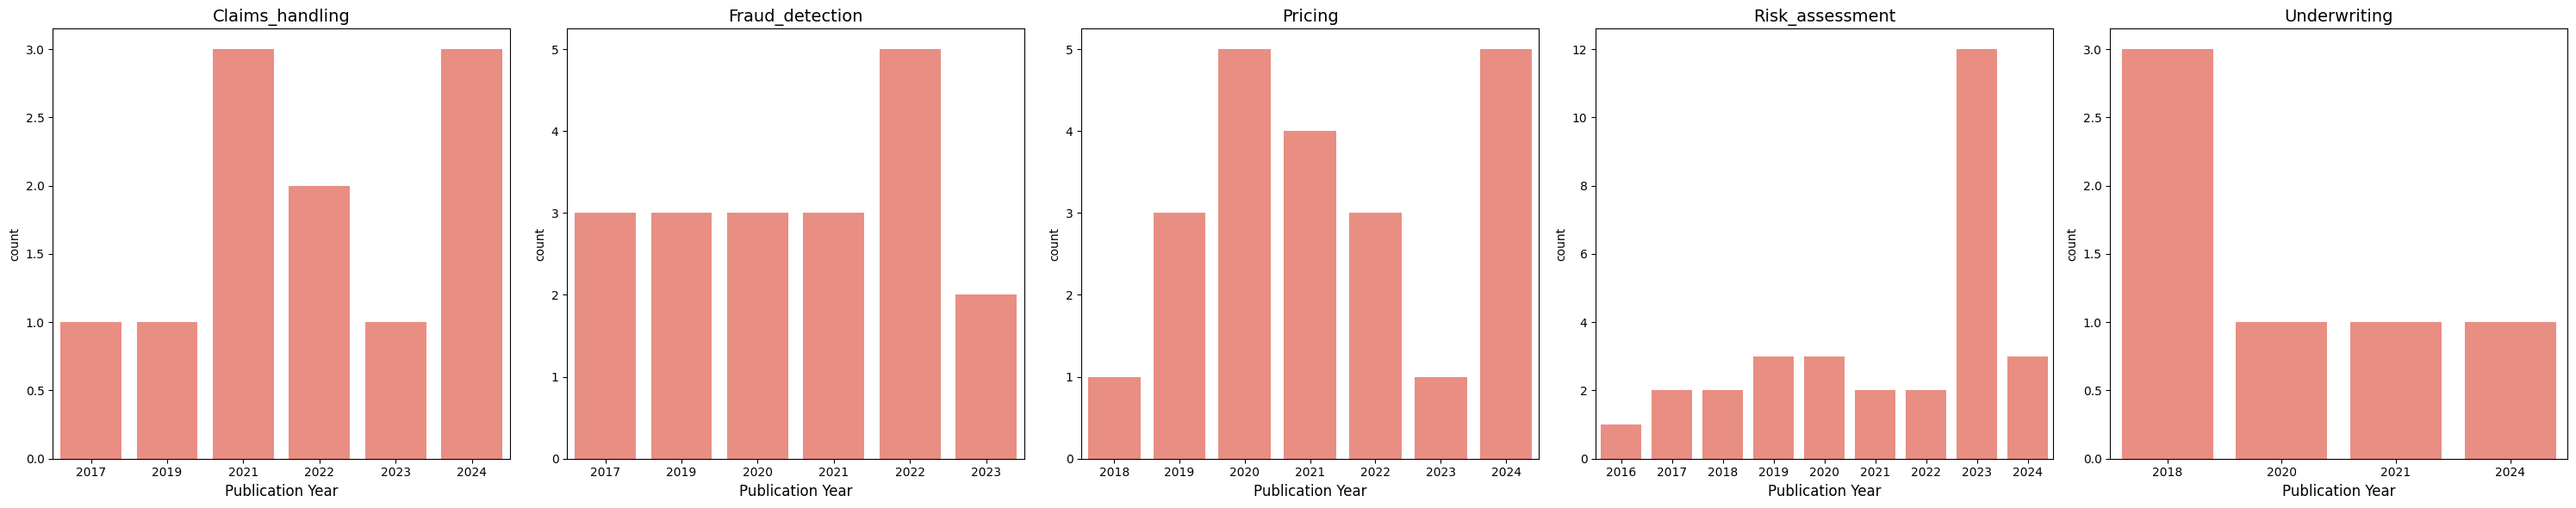

In [34]:
# Get unique subfolders
subdomains = df_word_counts['subdomain'].unique()

fig, axes = plt.subplots(
    nrows=1, 
    ncols=5, 
    figsize=(30, 6),  # Adjust width dynamically
    sharex=False, 
    sharey=False  # Allow each plot to have its own scales
)

# Iterate over subfolders and create a count plot for each
for ax, subdomain in zip(axes, subdomains):
    subset = df_word_counts[df_word_counts['subdomain'] == subdomain]
    
    sns.countplot(
        data=subset,
        x='publication_year',
        ax=ax,
        color='salmon',
        order=sorted(subset['publication_year'].unique())
    )
    
    # Customize subplot appearance
    ax.set_title(f'{subdomain}', fontsize=14)
    ax.set_xlabel('Publication Year', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


**4.2 References per subdomain**

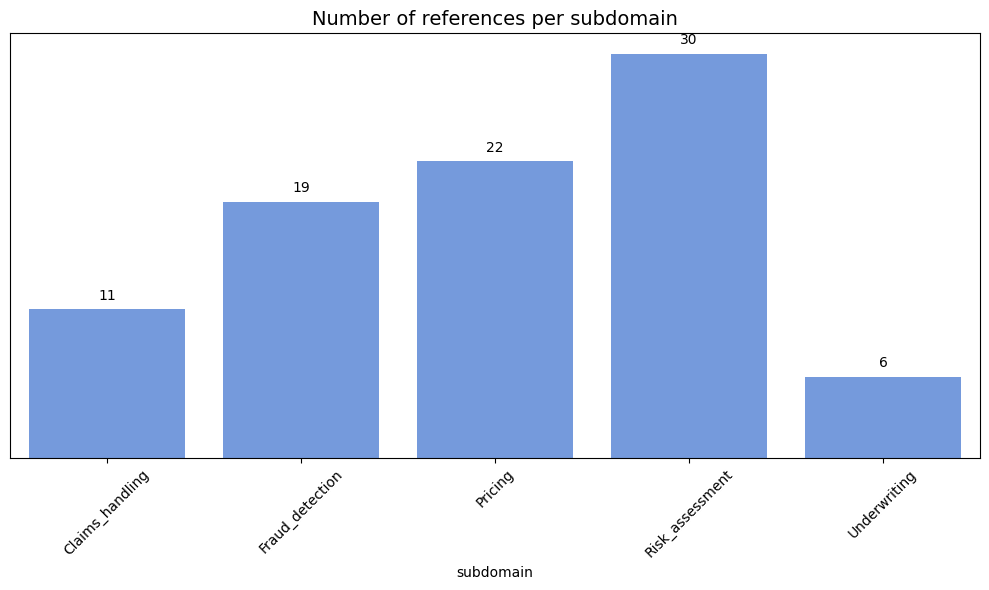

In [36]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_word_counts, x='subdomain', color='cornflowerblue', order=sorted(df_word_counts['subdomain'].unique()))

# Add data labels above each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

ax.yaxis.set_visible(False)

# Add titles and labels
plt.title('Number of references per subdomain', fontsize=14)
#plt.xlabel('#', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()